In [1]:
#import pkgs
import pandas as pd
import numpy as np
import requests
import string
import nltk
import matplotlib.pyplot as plt
from io import BytesIO
from statistics import mean
from sklearn.model_selection import KFold
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#load data from github
url = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset'
data = requests.get(url).content
smsData = pd.read_csv(BytesIO(data), sep = '\t', header = None, names = ['Category', 'SMS Message'])

#check data loaded as expected
smsData.head()

,Category,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#assign stopwords and punctuation to variables
stopWords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [4]:
#pre_Process function defined - list required for lemmatization step

def pre_Process(sms):
    
    #remove punctuation, toeknize and remove stopwords
    process = "".join([char.lower() for char in sms if char not in punctuation])
    tokenize = nltk.tokenize.word_tokenize(process)
    remove_stopwords = [word for word in tokenize if word not in stopWords]
    return remove_stopwords

#add processed column
smsData['Processed'] = smsData['SMS Message'].apply(lambda x: pre_Process(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [5]:
#define function for lemmatizing words

def lemm (sms):
    
    lem = [lemmatizer.lemmatize(word) for word in sms]
    return lem

#replace processed column with lemmatized column
smsData['Processed'] = smsData['Processed'].apply(lambda x: lemm(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"


In [6]:
#add cell with processed data as a string after processing
smsData['Processedstr'] = [' '.join(map(str, l)) for l in smsData['Processed']]

#assign 0 for ham and 1 for spam
for i in range(len(smsData['Category'])):
    if smsData.iloc[i, 0] == 'ham':
        smsData.iloc[i, 0] = 1
    else:
        smsData.iloc[i, 0] = 0

#remove unwanted columns
smsData = smsData[['Category', 'Processedstr']]

#check updated data frame
smsData.head()

,Category,Processedstr
0,1,go jurong point crazy available bugis n great ...
1,1,ok lar joking wif u oni
2,0,free entry 2 wkly comp win fa cup final tkts 2...
3,1,u dun say early hor u c already say
4,1,nah dont think go usf life around though


In [7]:
#split data into 10 folds to run model on each fold
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)

#counter
i = 0

#initiate empty lists and data frame
fold = []
acc = []
prec = []
rec = []
f1 = []
fprt = []
met = []
res = pd.DataFrame()

#split data/loop over each fold and run model 
for train_index, test_index in kf.split(smsData.Processedstr, smsData.Category):
    sms_train, sms_test, label_train, label_test = smsData.Processedstr[train_index], smsData.Processedstr[test_index], smsData.Category[train_index], smsData.Category[test_index]
    
    #labels as integers
    label_train = label_train.astype('int')
    label_test = label_test.astype('int')
    
    #fit and transform training and test data
    vect = CountVectorizer().fit(sms_train)
    train_vectorized = vect.transform(sms_train)
    
    #fitting a multinomial Naive Bayes Classifier Model with smoothing alpha=0.1
    model = MultinomialNB(alpha=0.1)
    model_fit = model.fit(train_vectorized, label_train)

    #making predictions
    train_predict = model.predict(vect.transform(sms_test))

    #run confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_test, train_predict, labels = [1, 0]).ravel()
    
    #calculate accuracy, precision, recall, F1 score, False Positive Rate
    a = (tp + tn)/(tp + fp + fn + tn)
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    f = (2 * (p * r))/(p + r)
    fpr = fp / (tn + fp)
    
    i = i + 1
    
    #append results to each empty list
    fold.append(i)
    acc.append(a)
    prec.append(p)
    rec.append(r)
    f1.append(f)
    fprt.append(fpr)
    met.append([tp, fp, tn, fn])

#fill dataframe with results from the model/cross-validation 
res['Fold'] = fold    
res['Accuracy'] = acc
res['Precision'] = prec
res['Recall'] = rec
res['F1'] = f1
res['FPR'] = fprt
res['Metrics'] = met

res

,Fold,Accuracy,Precision,Recall,F1,FPR,Metrics
0,1,0.991039,0.962963,0.975000,0.968944,0.006276,"[78, 3, 475, 2]"
1,2,0.989247,0.968254,0.938462,0.953125,0.004057,"[61, 2, 491, 4]"
2,3,0.983842,0.960000,0.923077,0.941176,0.006263,"[72, 3, 476, 6]"
3,4,0.985637,0.946667,0.946667,0.946667,0.008299,"[71, 4, 478, 4]"
4,5,0.978456,0.939759,0.917647,0.928571,0.010593,"[78, 5, 467, 7]"
5,6,0.989228,0.939024,0.987179,0.962500,0.010438,"[77, 5, 474, 1]"
6,7,0.971275,0.934426,0.826087,0.876923,0.008197,"[57, 4, 484, 12]"
7,8,0.980251,0.907895,0.945205,0.926174,0.014463,"[69, 7, 477, 4]"
8,9,0.978456,0.960526,0.890244,0.924051,0.006316,"[73, 3, 472, 9]"
9,10,0.982047,0.919355,0.919355,0.919355,0.010101,"[57, 5, 490, 5]"


In [8]:
#split list of list in dataframe
split = pd.DataFrame(res['Metrics'].to_list(), columns = ['TP', 'FP', 'TN', 'FN'])

#add split columns to results dataframe
res = pd.concat([res, split], axis = 1)

#drop combined columns
res.drop(columns = 'Metrics', inplace = True)

#check results dataframe
res

,Fold,Accuracy,Precision,Recall,F1,FPR,TP,FP,TN,FN
0,1,0.991039,0.962963,0.975000,0.968944,0.006276,78,3,475,2
1,2,0.989247,0.968254,0.938462,0.953125,0.004057,61,2,491,4
2,3,0.983842,0.960000,0.923077,0.941176,0.006263,72,3,476,6
3,4,0.985637,0.946667,0.946667,0.946667,0.008299,71,4,478,4
4,5,0.978456,0.939759,0.917647,0.928571,0.010593,78,5,467,7
5,6,0.989228,0.939024,0.987179,0.962500,0.010438,77,5,474,1
6,7,0.971275,0.934426,0.826087,0.876923,0.008197,57,4,484,12
7,8,0.980251,0.907895,0.945205,0.926174,0.014463,69,7,477,4
8,9,0.978456,0.960526,0.890244,0.924051,0.006316,73,3,472,9
9,10,0.982047,0.919355,0.919355,0.919355,0.010101,57,5,490,5


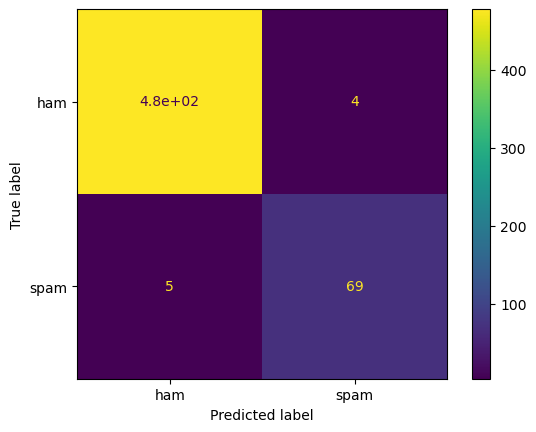

In [9]:
#average results for visualization
TP = round(mean(res['TP']),0)
FP = round(mean(res['FP']),0)
TN = round(mean(res['TN']),0)
FN = round(mean(res['FN']),0)

#create array with confusion matrix results
data = np.array([[TN, FP], [FN, TP]])

#create matrix
cm_display = metrics.ConfusionMatrixDisplay(data, display_labels = ['ham', 'spam'])

#plot
cm_display.plot()
plt.show()

In [10]:
#store list to for use in statistical comparison
f1_nb_case3 = res.loc[:,'F1'].tolist()
fpr_nb_case3 = res.loc[:,'FPR'].tolist()

%store f1_nb_case3
%store fpr_nb_case3

Stored 'f1_nb_case3' (list)
Stored 'fpr_nb_case3' (list)
